#House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install vecstack

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19863 sha256=0c5454a2bd40269ac6a06a7be8331513e7a5cf5e8b5bf961e6b48205d76929d2
  Stored in directory: /root/.cache/pip/wheels/b8/d8/51/3cf39adf22c522b0a91dc2208db4e9de4d2d9d171683596220
Successfully built vecstack


In [3]:
from vecstack import stacking
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [4]:
#Read training data file
trainfile = '/content/drive/MyDrive/house_train.csv'
trainData = pd.read_csv(trainfile)

#Read test data file
testfile = '/content/drive/MyDrive/house_test.csv'
testData = pd.read_csv(testfile)

print(trainData.shape)
print(testData.shape)

(1460, 81)
(1459, 80)


#EDA

In [5]:
trainData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
trainData['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

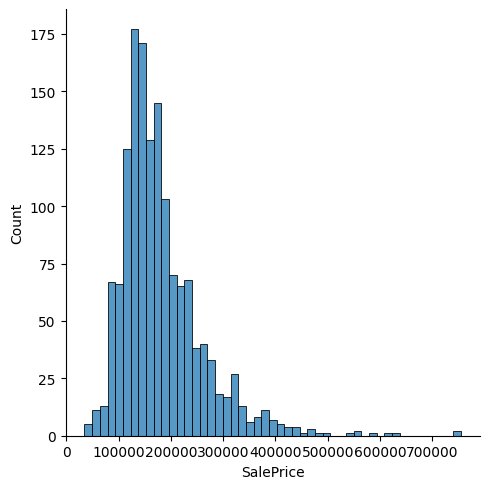

In [ ]:
sns.displot(trainData['SalePrice']);


#DATA PRE-PROCESSING

In [6]:
train_ID = trainData['Id']
test_ID = testData['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
trainData.drop("Id", axis = 1, inplace = True)
testData.drop("Id", axis = 1, inplace = True)

In [7]:
Ytrain = trainData['SalePrice']
combinedData = pd.concat([trainData,testData], keys=[0,1])
combinedData.drop(['SalePrice'], axis=1, inplace=True)
combinedData.shape

(2919, 79)

#MISSING DATA

In [8]:
missing_values = combinedData.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [9]:
na_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in na_cols:
    combinedData[col].fillna("None", inplace=True)

zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in zero_cols:
    combinedData[col].fillna(0, inplace=True)

combinedData["LotFrontage"] = combinedData.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

combinedData.drop(['Utilities'], axis=1, inplace = True)

mode_cols = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType', 'Electrical']
for col in mode_cols:
    mode = combinedData[col].mode()[0]
    combinedData[col].fillna(mode, inplace=True)



In [10]:
missing_values = combinedData.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

Series([], dtype: int64)

#CATEGORICAL FEATURES

In [11]:
#Changing features into a categorical variable

combinedData['MSSubClass'] = combinedData['MSSubClass'].apply(str)
combinedData['OverallCond'] = combinedData['OverallCond'].astype(str)
combinedData['OverallQual'] = combinedData['OverallQual'].astype(str)

In [12]:
combinedData.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (0, 0) to (1, 1458)
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   object 
 16  OverallCond    2919 non-null   object 
 17  YearBuilt      2919 non-null   int64  
 18

In [13]:
#Apply LabelEncoder to categorical features which can be ordered

label_cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in label_cols:
    lbl = LabelEncoder()
    lbl.fit(list(combinedData[c].values))
    combinedData[c] = lbl.transform(list(combinedData[c].values))

combinedData.shape

(2919, 78)

In [14]:
categorical_columns = combinedData.select_dtypes(include=['object', 'category']).columns
TrainCols = list(categorical_columns.values)
print(TrainCols)

['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


In [15]:
combinedData = pd.get_dummies(combinedData)
combinedData.shape

(2919, 229)

In [16]:
Xtrain = combinedData.xs(0)
Xtest = combinedData.xs(1)

Xtrain.to_csv('new_train_hw4.csv', index=False)
Xtest.to_csv('new_test_hw4.csv', index=False)
Ytrain.to_csv('new_ytrain_hw4.csv', index=False)


#Decision Tree Regressor

In [ ]:
#Decision Tree Regressor

dtr = DecisionTreeRegressor()
dtr.fit(Xtrain, Ytrain)
dtr_train_pred = dtr.predict(Xtrain)

dtr_mse = mean_squared_error(Ytrain, dtr_train_pred)
dtr_rmse = sqrt(dtr_mse)
print("RMSE (training) for Decision Tree:{0:5f}".format(dtr_rmse))

dtr_test_pred = dtr.predict(Xtest)

RMSE (training) for Decision Tree:0.000000


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': dtr_test_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv('DTR1.csv', index=False)

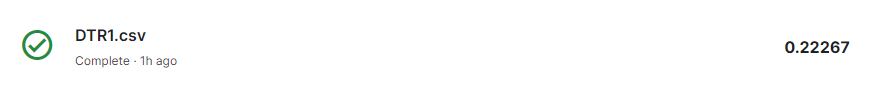

In [ ]:
#HYPER PARAMETER TUNING

dt_param_grid = {
    'max_depth': [9 , 10, 11, 12],
    'min_samples_split': [9, 10, 11, 12],
    'min_samples_leaf': [3, 4, 5]
}

dt_grid_search = GridSearchCV(dtr, dt_param_grid, cv=5, n_jobs=-1, verbose=2)
dt_grid_search.fit(Xtrain, Ytrain)
dt_best_params = dt_grid_search.best_params_
print(dt_best_params)

dt_model_optimized = DecisionTreeRegressor(**dt_best_params)
dt_model_optimized.fit(Xtrain, Ytrain)

dt_predictions_optimized = dt_model_optimized.predict(Xtest)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 12}


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': dt_predictions_optimized
})

# Save the DataFrame to a CSV file
result_df.to_csv('DTR2.csv', index=False)

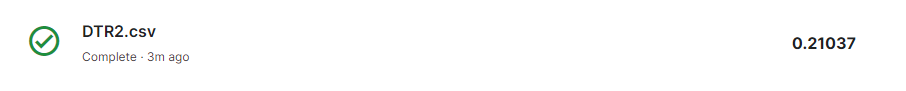

#Random Forest Regressor


In [ ]:
#Random Forest Regressor

rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(Xtrain, Ytrain)
rfr_train_pred = rfr.predict(Xtrain)

rfr_mse = mean_squared_error(Ytrain, rfr_train_pred)
rfr_rmse = sqrt(rfr_mse)
print("RMSE (training) for Random Forest:{0:5f}".format(rfr_rmse))

rfr_test_pred = rfr.predict(Xtest)

RMSE (training) for Random Forest:11066.788871


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': rfr_test_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv('RFR1.csv', index=False)

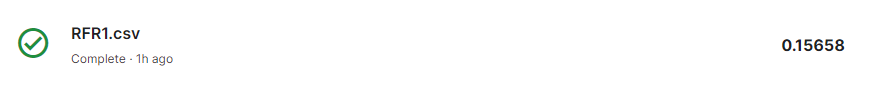

In [ ]:
#HYPER PARAMETER TUNING

rf_param_grid = {
    'n_estimators' : [50, 75, 100],
    'max_depth': [9 , 10, 11, 12],
    'min_samples_split': [9, 10, 11, 12],
    'min_samples_leaf': [3, 4, 5]
}

rf_grid_search = GridSearchCV(rfr, rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(Xtrain, Ytrain)
rf_best_params = rf_grid_search.best_params_
print(rf_best_params)

rf_model_optimized = RandomForestRegressor(**rf_best_params)
rf_model_optimized.fit(Xtrain, Ytrain)

rf_predictions_optimized = rf_model_optimized.predict(Xtest)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': rf_predictions_optimized
})

# Save the DataFrame to a CSV file
result_df.to_csv('RFR2.csv', index=False)

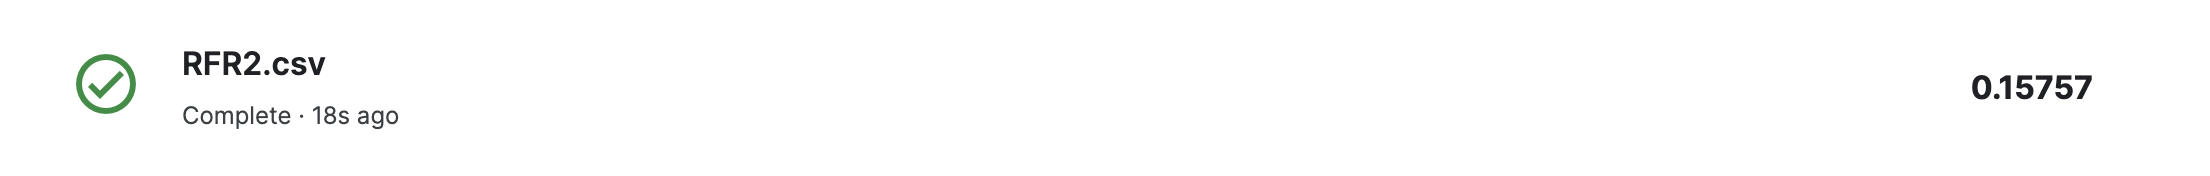

#Gradient Boosting Regressor


In [ ]:
#Gradient Boosting Regressor

gbr = GradientBoostingRegressor()
gbr.fit(Xtrain, Ytrain)
gbr_train_pred = gbr.predict(Xtrain)

gbr_mse = mean_squared_error(Ytrain, gbr_train_pred)
gbr_rmse = sqrt(gbr_mse)
print("RMSE (training) for Gradient Boosting:{0:5f}".format(gbr_rmse))


gbr_test_pred = gbr.predict(Xtest)

RMSE (training) for Gradient Boosting:14897.509250


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': gbr_test_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv('GBR1.csv', index=False)

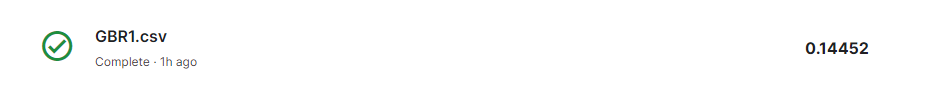

In [ ]:
#HYPER PARAMETER TUNING

gb_param_grid = {
    'n_estimators' : [50, 75, 100],
    'max_depth': [9 , 10, 11, 12],
    'min_samples_split': [9, 10, 11, 12],
    'min_samples_leaf': [3, 4, 5]
}

gb_grid_search = GridSearchCV(gbr, gb_param_grid, cv=3, n_jobs=-1, verbose=2)
gb_grid_search.fit(Xtrain, Ytrain)
gb_best_params = gb_grid_search.best_params_
print(gb_best_params)

gb_model_optimized = GradientBoostingRegressor(**gb_best_params)
gb_model_optimized.fit(Xtrain, Ytrain)

gb_predictions_optimized = gb_model_optimized.predict(Xtest)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}


In [ ]:
result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': gb_predictions_optimized
})

# Save the DataFrame to a CSV file
result_df.to_csv('GBR2.csv', index=False)

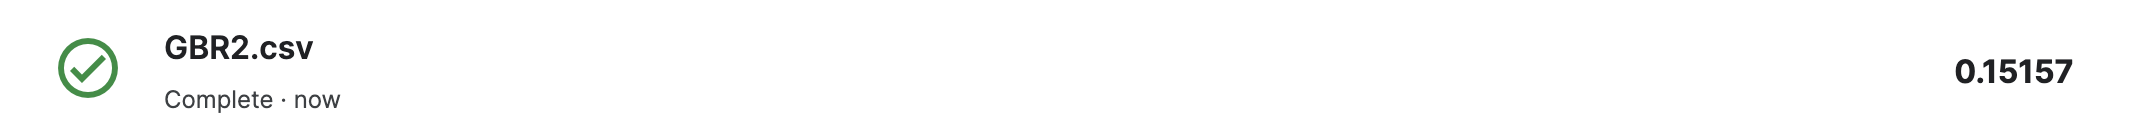

#STACKING

In [17]:
models = [ GradientBoostingRegressor(), RandomForestRegressor(n_jobs = -1), DecisionTreeRegressor()]

S_Train, S_Test = stacking(models,
                           Xtrain, Ytrain, Xtest,
                           regression=True,
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           n_folds=5,
                           shuffle=True,
                           random_state=7,
                           verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]
    fold  0:  [15901.49250336]
    fold  1:  [16127.17438928]
    fold  2:  [20096.37355102]
    fold  3:  [14477.68052167]
    fold  4:  [16533.09588772]
    ----
    MEAN:     [16627.16337061] + [1867.67939830]
    FULL:     [16627.16337061]

model  1:     [RandomForestRegressor]
    fold  0:  [17472.38794521]
    fold  1:  [16929.23636986]
    fold  2:  [20827.61965753]
    fold  3:  [16203.15452055]
    fold  4:  [17453.12099315]
    ----
    MEAN:     [17777.10389726] + [1593.71635630]
    FULL:     [17777.10389726]

model  2:     [DecisionTreeRegressor]
    fold  0:  [25471.59931507]
    fold  1:  [26417.06506849]
    fold  2:  [30505.46917808]
    fold  3:  [24259.41438356]
    fold  4:  [25136.48630137]
    ----
    MEAN:     [26358.00684932] + [2185.71968674]
    FULL:     [26358.00684932]



In [18]:
stacked_model = GradientBoostingRegressor()
stacked_model.fit(S_Train,Ytrain)
stacked_pred = stacked_model.predict(S_Test)

result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': stacked_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv('STACKED.csv', index=False)

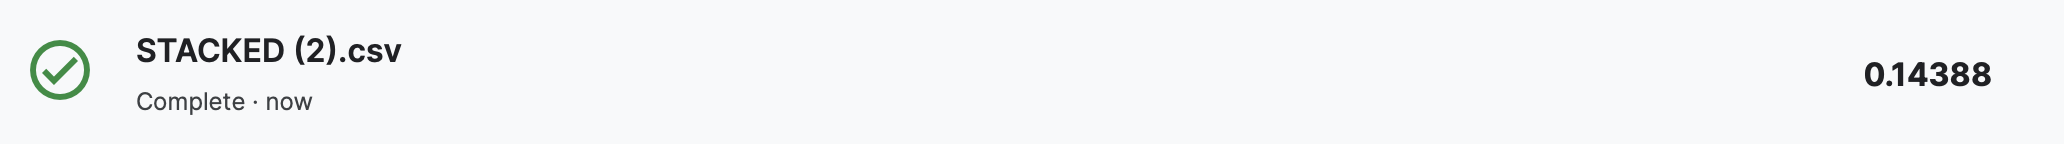

In [19]:
#HYPER PARAMETER TUNING OF STACKED MODEL

param_grid_meta = {
    'n_estimators' : [75, 100, 150],
    'max_depth': range(5,20,2),
    'min_samples_split': range(1,15,2),
    'min_samples_leaf': range(1,15,2)
}

random_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_grid_meta,
                                   n_iter=25, cv=5, random_state=7,verbose=2)

random_search.fit(S_Train, Ytrain)
best_param = random_search.best_params_
print(best_param)
#CV_mlp = GridSearchCV(estimator=model, param_grid=param_grid_meta, cv=5,n_jobs =-1, verbose = 1)
#CV_mlp.fit(S_Train, y_res1)
#print(CV_mlp.best_params_)

final_model = GradientBoostingRegressor(**best_param)
final_model.fit(S_Train, Ytrain)
final_y_pred = final_model.predict(S_Test)


result_df = pd.DataFrame({
    'ID': test_ID,
    'SalePrice': final_y_pred
})

# Save the DataFrame to a CSV file
result_df.to_csv('STACKED1.csv', index=False)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END max_depth=13, min_samples_leaf=11, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=13, min_samples_leaf=11, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=13, min_samples_leaf=11, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=13, min_samples_leaf=11, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=13, min_samples_leaf=11, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=17, min_samples_leaf=7, min_samples_split=3, n_estimators=150; total time=   0.9s
[CV] END max_depth=17, min_samples_leaf=7, min_samples_split=3, n_estimators=150; total time=   1.3s
[CV] END max_depth=17, min_samples_leaf=7, min_samples_split=3, n_estimators=150; total time=   1.3s
[CV] END max_depth=17, min_samples_leaf=7, min_samples_split=3, n_estimators=150; total time=   1.3s
[CV] END max_depth=17, m

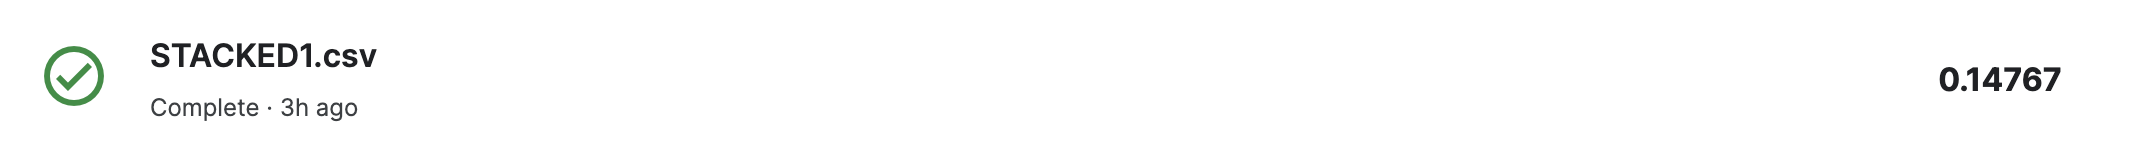

#CONCLUSION
In this assignment, we worked with regressors to predict the value of the target variable. We also used stacking to combine predictions from different regressors to get a final prediction from the meta-model.
We also handled missing values using various methods.

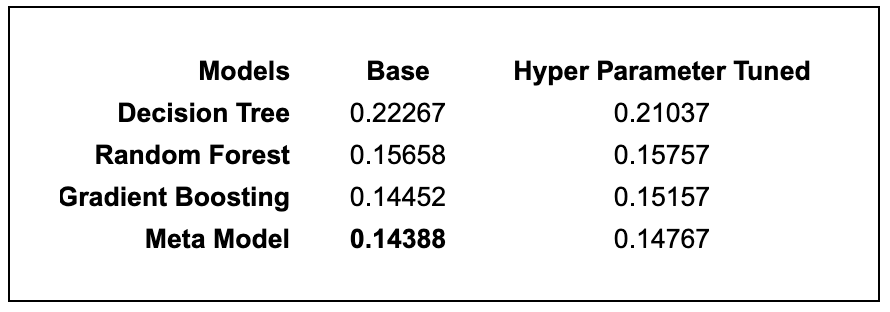